# Time Dependent Schroedinger Equation Solver
$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
## The Time Dependent Schroedinger Equation

Here we develop code to solve the time dependent Schroedinger equation (TDSE) using the Fourier split-operator method. In Dirac notation, the TDSE is written as follows:

$$i\hbar\frac{d}{dt}\ket{\Psi(x,t)} = \hat{H}\ket{\Psi(x,t)}$$

From this form, it is relatively easy to check that the solution to this partial differential equation is the following:

$$\ket{\Psi(x,t+\tau)} = \exp(-\frac{i\hat{H}\tau}{\hbar})\ket{\Psi(x,t)}$$

Now in this form we see that we have a propagator, $\hat{U}(\tau) = \exp(-\frac{i\hat{H}\tau}{\hbar})$, which is responsible for time evolution. We should now go into more detail about the Hamiltonian operator, $\hat{H}$, which encodes all of the information of our particular system. For the time being, let's assume that $\hat{H} = \hat{H}_\mathbf{r}+\hat{H}_\mathbf{k}$, respectively potential and kinetic operators. We neglect any angular momentum operators and assume a spherically symmetric system, with a radial coordinate. Expressing the TDSE in a position basis as follows:

$$i\hbar\frac{\partial}{\partial t}\Psi(x,t) = \left[-\frac{\hbar^2}{2m}\nabla^2 + V(x,t) \right]\Psi(x,t)$$

we can extract the potential and kinetic operators:

$$\hat{H}_\mathbf{r} = V(\mathbf{r})$$
$$\displaystyle{\hat{H}_\mathbf{k} = -\frac{\hbar^2}{2m}\nabla^2}$$

However, implementing the Laplace operator, $\nabla^2$ is quite tricky in position space. It is very easy in momentum space though, if we can just take a Fourier transform of our wavefunction into momentum space. This is what the Fourier split-operator method exploits, as described in the next section.

## Fourier Transforms

Before we state what the Fourier split-operator method is, we should quickly explain Fourier transforms as we will be using them to go between position and momentum space. The basic difference between position and momentum space is the co-ordinates that we use to specify objects. In position space, we use the object's position, while in momentum space we use the object's momentum. The relationship between position and momentum can be found from Heisenberg's uncertainty principle and is equal to $\displaystyle{k_{max} = \frac{2\pi}{\Delta x}}$.

In d-dimensional space, we use the forward Fourier transform to rewrite a wavefunction in position space ($\phi(\mathbf{r})$) in terms of its momentum ($\mathbf{k}$):

$$\phi (\mathbf{k}) = \frac{1}{(2\pi)^d}\int_{\mathbf{r}}d^d\mathbf{r}\phi(\mathbf{r})e^{-i\mathbf{k}\cdot\mathbf{r}}$$

Then, going the other way (momentum space to position space), we use the backwards Fourier transform:

$$\phi (\mathbf{r}) = \int_{\mathbf{k}}d^d\mathbf{k}\phi(\mathbf{k})e^{i\mathbf{k}\cdot\mathbf{r}}$$

Examining the expression for the wavefunction in position space, we see that applying the Laplace operator is very easy in momentum space:

$$\nabla^2 \phi (\mathbf{r}) = -k^2\int_{\mathbf{k}}d^d\mathbf{k}\phi(\mathbf{k})e^{i\mathbf{k}\cdot\mathbf{r}}$$

which just corresponds to a scaling of $\phi(\mathbf{k}) \rightarrow -k^2\phi(\mathbf{k})$ in momentum space. This makes our code much simpler and more efficient if we can efficiently execute these Fourier transforms.

### mpi4py-fft

Thus, let's look at a useful Python package which allows for parallelisation of Fast Fourier Transforms called mpi4py-fft. Below is included a minimal working example, but further details can be found in the documentation [here](https://mpi4py-fft.readthedocs.io/en/latest/).

In [3]:
import numpy as np
from mpi4py import MPI
from mpi4py_fft import PFFT, newDistArray

comm = MPI.COMM_WORLD
N = np.array([128, 128, 128], dtype=int)  #this just gives dimensions for our grid! => dtype = int

"""Need to plan each Fourier transform by creating a PFFT object with some optimised specifications"""
#planned for array of shape N, grid=(-1,1) says that the grid will be distributed in the first index
    #i.e. wherever the -1 is
#axes=(0,1) means that the second axis will be transformed first, followed by the first
#The type of the array to be transformed is set to be float. Can change to np.complex

fft = PFFT(comm, N, axes=(0, 1, 2), dtype=np.float, grid=(-1,1,1))

#creating the distributed array below. Set False when creating the input array. True is the default which is for generating output arrays.
u = newDistArray(fft, False)   

#filling up our array with random numbers
u[:] = np.random.random(u.shape).astype(u.dtype) 

#performing the Forward Fourier Transform
u_hat = fft.forward(u, normalize=True) # Note that normalize=True is default and can be omitted

#creating a distributed array to send the Backwards Fourier Transform into.
uj = np.zeros_like(u)

#performing the Backward Fourier Transform
uj = fft.backward(u_hat)

#checking that the original array equals to the final array
assert np.allclose(uj, u)
print(comm.Get_rank(), u.shape)

0 (128, 128, 128)


## Fourier Split-Operator Method

Now that we have an idea of how to perform Fourier transforms, let's go into the details of the Fourier split-operator method. The Fourier split-operator method is well-suited to implement time evolution. 

Firstly, recall that our Hamiltonian operator is equal to: $\hat{H} = \hat{H}_\mathbf{r}+\hat{H}_\mathbf{k}$, which means that our propagator is equal to $\displaystyle{\hat{U}(\tau) = \exp\left(-\frac{i(\hat{H}_\mathbf{r}+\hat{H}_\mathbf{k})\tau}{\hbar}\right)}$. 

Using the Baker–Campbell–Hausdorf formula and the 2$^{nd}$ order Strang splitting, we can simplify this expression to an approximate solution of $\mathcal{O}(\tau^3)$. The resulting operator that we must implement is equal to 

$$\exp\left(-\frac{i\hat{H}_\mathbf{r}+\hat{H}_\mathbf{k}\tau}{\hbar}\right) = \exp\left(-\frac{i\hat{H}_{\mathbf{r}}\tau}{2\hbar}\right)\exp\left(-\frac{i\hat{H}_{\mathbf{k}}\tau}{\hbar}\right)\exp\left(-\frac{i\hat{H}_{\mathbf{r}}\tau}{2\hbar}\right) + \mathcal{O}(\tau^3)$$

We apply each of these 3 operators from right to left. Now we see that we can take Fourier transforms sparsed in between these 3 operators so we can make our lives easier for ourselves. A single time-step in the Fourier split-operator method looks like the following, where $\mathcal{F}$ represents a Fourier transform: ![title](Resources/fourier_split_operator.png)

### Imaginary Time Evolution

These operators allow for time evolution. In other words, if we have a wavefunction at time $t$, and want to know what it is at time $t+\tau$, we apply the above method. However, there is one more trick that we can use called imaginary time evolution. 

If we perform a Wick rotation, $t \rightarrow -it$, we can go to imaginary time. This will change the behaviour of all of our propagators from oscillatory to decaying: $\exp\left(-it\right) \rightarrow \exp\left(-t\right)$. Now, if we set an initial wavefunction which has some overlap with the ground state of our system, then our wavefunction will simply decay to the ground state. The ground state is just the state with the lowest energy. Importantly though, we must ensure that our wavefunction remains normalised, $|\phi|^2 = 1$, so we must normalise the wavefunction after every time step when we evolve the system in imaginary time due to the decaying nature of the propagators. Thus, we can find the ground state of any solution to the TDSE! 

## Code!

Now let's start putting the full code to this algorithm. We begin by importing necessary packages and defining basic parameters.

In [29]:
#--------------necessary packages-------------------

import matplotlib.pylab as plt
import numpy as np
from scipy.constants import pi
from mpi4py import MPI
from mpi4py_fft import PFFT, newDistArray, DistArray
from sys import stdout
from matplotlib.animation import FuncAnimation
#module for calculating the analytic solution for the ground state
import tiseAnalytic as an
#module for calculating the energy of the wavefunction
import energy

%matplotlib inline

In [9]:
#----------setting up basic parameters---------------

"""Physical Parameters"""
m = 1           #mass of particle
hbar=1
t0 = 0.0        #initial time
w = 1           #frequency of potential = 1/2*m*w^2*x^2

"""Numeric Parameters"""
N = 512         #resolution of grid
xMax = 100
yMax = xMax
h = 0.01        #time resolution
tol = 1e-5

Now we write some functions to help ensure that the wavefunction is always normalised. Note that the code is parallelised for efficiency. 

In [10]:
#----------------Normalising Functions---------------

def fullNorm(x):                #returns the full norm from list of norms from each core
    return np.linalg.norm(x)
    
def normalise(u):
    part_norm = np.linalg.norm(u)          #get the norm of each section of wavefuntion
    norms = comm.gather(part_norm, root=0)
    if rank==0:
        norm = fullNorm(norms)             #combine all the norms into total norm
    else:
        norm = None
    norm = comm.bcast(norm,root=0)         #send out the total norm to all cores
    return u/norm

Now we set up the communicators for our multi-threaded processes. We also set up the Fast Fourier Transform object as we showed earlier. We can ignore the casting complex numbers to real numbers warning. Finally, we set up buffers that will be necessary later when we collect the full wavefunction onto a single core for plotting and analysis!

In [11]:
#-------setting up the communicator for MPI----------

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

#-----setting up the Fast Fourier Transform----------

N2D = np.array([N, N], dtype=int)
fft = PFFT(comm, N2D, axes=(1,0), dtype=np.complex, grid=(1,-1,))  #defaults to rfftn for real input array.

#-----------setting up initial conditions------------

u = newDistArray(fft, False)                 #creating the distributed array for the input of fft
k = newDistArray(fft, True)                  #creating the distributed array for the output of fft

UrI = newDistArray(fft, True)
UrR = newDistArray(fft, True).astype(np.float)
UkI = newDistArray(fft, True)
UkR = newDistArray(fft, True).astype(np.float)

if rank==0:                                  #necessary buffers
    groundState = np.ones(N2D).astype(u.dtype)*-1
    buff = np.ones(N2D).astype(u.dtype)*-1
    V = np.ones(N2D).astype(u.dtype)
    P = np.ones(N2D).astype(u.dtype)
else:
    groundState = None
    buff = None

<ipython-input-11-f94f10e9f680>:18: ComplexWarning: Casting complex values to real discards the imaginary part
  UrR = newDistArray(fft, True).astype(np.float)
<ipython-input-11-f94f10e9f680>:20: ComplexWarning: Casting complex values to real discards the imaginary part
  UkR = newDistArray(fft, True).astype(np.float)


Now we create the propagators, $\hat{U}_{\mathbf{r}}$ and $\hat{U}_{\mathbf{k}}$, and we distribute them across all of our cores. Note that we do this for a harmonic potential: 

$$V(\mathbf{r}) = \frac{1}{2}mw^2r^2$$

In [13]:
#-------Functions to generate the propagators--------

pxMax = (pi/xMax)*N/2
pyMax = (pi/yMax)*N/2
dx = 2*xMax/N
dy = 2*yMax/N
dpx = pi/xMax
dpy = pi/yMax

x = np.zeros(N)
y = np.zeros(N)
xp = np.zeros(N)
yp = np.zeros(N)

for i in range(int(N/2)):
    x[i] = -xMax + (i+1)*dx
    x[i + int(N/2)] = (i+1)*dx
    
    y[i] = -yMax + (i+1)*dy
    y[i + int(N/2)] = (i+1)*dy
    
    xp[i] = (i+1)*dpx
    xp[i + int(N/2)] = -pxMax + (i+1)*dpx
    
    yp[i] = (i+1)*dpy
    yp[i + int(N/2)] = -pyMax + (i+1)*dpy
    
def radiusSq(x,y):         #simple radius function
    return x**2+y**2

#--------Ur

def harmonicPotential(x):          #creates V(r) matrix for harmonic potential
    return 0.5*m*w**2*x

def spaceProp(m,w):                #generates propagators and V matrix - GLOBAL

    global UrR, UrI, V
    
    if rank==0:
        X,Y = np.meshgrid(x,y)
        R = radiusSq(X,Y)

        V = harmonicPotential(R)

        UrRtemp = np.exp(-V*h/2.0/hbar)    #NxN matrix = exp(-V(r)*h/2*hbar). imaginary time evolution. t -> -it
        UrItemp = np.exp(-1j*V*h/2.0/hbar).astype(u.dtype)
    else:
        UrRtemp = None
        UrItemp = None

    comm.Scatter(UrRtemp,UrR,root=0)
    comm.Scatter(UrItemp,UrI,root=0)

#---------Uk

def momProp(m,w):                   #generates propagators and V matrix - GLOBAL

    global UkR, UkI, P

    if rank==0:
        KX, KY = np.meshgrid(xp,yp)
        K = radiusSq(KX,KY)
        P = (hbar)**2*K/2.0/m

        UkRtemp = np.exp(-P*h/hbar)   #NxN matrix = exp(P(k)*h/hbar). P(k) = (hbar*k)**2/2m. k = 2pi/x. t -> -it.
        UkItemp = np.exp(-1j*P*h/hbar).astype(u.dtype)
    else:
        UkRtemp = None
        UkItemp = None

    comm.Scatter(UkRtemp,UkR,root=0)
    comm.Scatter(UkItemp,UkI,root=0)

stdout.flush()
comm.barrier()

Finally, we are ready to define a function to implement a time step of the Fourier split-operator method. This function has two arguments, $\hat{U}_{\mathbf{r}}$ and $\hat{U}_{\mathbf{k}}$, so that we can either feed in the real or imaginary time evolution operators.

In [14]:
#---implementing the Fourier split-operator method---

def fso_step(Ur,Uk):

    global groundState, buff, u, k

    #Apply first Ur here
    
    u = u.redistribute(1)
    u = np.multiply(u,Ur)
    u = u.redistribute(0)
    
    #Forward FFT here
    
    k = fft.forward(u, k)
    
    #Apply Uk here

    k = np.multiply(k,Uk)
    
    #Backward FFT here
    
    u = fft.backward(k, u)
    
    #Second Ur here
    
    u = u.redistribute(1)
    u = np.multiply(u,Ur)
    u = u.redistribute(0)
    
    #Normalise here
    
    u = normalise(u)

Now, we can put everything together and write a function to find the ground state of the Schroedinger equation for a harmonic potential.

In [15]:
#------------find Ground State Function--------------

def findGround(Ur,Uk):

    global u0, done, allDone
    
    fso_step(Ur,Uk)
    if np.allclose(u,u0,tol):
        done=1
    allDone = comm.allgather(done)             #so that every core knows the 'done' status of every other core

    t=t0

    while np.sum(allDone)<size:                #main body of code
        if np.allclose(u,u0,tol):
            done=1
        allDone = comm.allgather(done)
        
        u0 = u
        fso_step(Ur,Uk)
        t+=h
        
        #if rank==0:
        #    print(t)
        
        stdout.flush()
        comm.barrier()

In [16]:
"""-------------------------------------------------------------------"""
#-----------------------Running Main Code Here---------------------------
"""-------------------------------------------------------------------"""

allDone = np.zeros(size)                    #for synchronising the while loops on all cores
done = 0                                    #done = 1 on each core when local while loop ends

"""set the initial wavefunction here"""

u[:] = np.random.rand(*u.shape).astype(u.dtype) + np.random.rand(*u.shape).astype(u.dtype)*1j

u = normalise(u)
u0 = u                                       #copying the initial state

spaceProp(m,w)
momProp(m,w)

findGround(UrR, UkR)

if rank==0:
    print("Ground State Reached")

Ground State Reached


## Results & Analysis

### Energy

We can compute the energy of the ground state. The code for which can be found in energy.py. Note that we set $\omega = 1$, and we are working in 2D, so we would expect the energy to equal: 

$$E = 2\times\frac{1}{2}\hbar\omega = 1$$

The energy contribution from position term can be computed as:

$$E_v = \int dr \Psi(r)^{+}V\Psi(r)$$

while the energy contribution from momentum term can be computed by first Fourier transforming to momentum space, and then applying this formula:


$$E_k = \int dk \Psi^{+}(k)K\Psi(k)$$

In [17]:
#----------------Analytic Solution-------------------

if rank==0:
    analyticGroundState = an.main(m,hbar,w,N,xMax,yMax)

#----------------Collecting Solutions----------------

u = u.redistribute(1)
comm.Gather(u,groundState,root=0)
u = u.redistribute(0)

k = fft.forward(u, k)
k = normalise(k)
comm.Gather(k,buff,root=0)

if rank==0:

    print("final norm = ", np.linalg.norm(groundState))
    print("momentum norm = ", np.linalg.norm(buff))

    spaceE = energy.energy(groundState,V)
    momE = energy.energy(buff,P)
    totalE = spaceE + momE

    print("spatial contribution: ", spaceE)
    print("momentum contribution: ", momE)
    print("Total Energy: ", totalE)

final norm =  0.9999999999999998
momentum norm =  1.0000000000000002
spatial contribution:  (0.4999979024565804-1.3685151169640161e-18j)
momentum contribution:  (0.5000021714103214-1.2091395322055137e-19j)
Total Energy:  (1.000000073866902-1.4894290701845675e-18j)


### Plotting

We can now plot this ground state and compare it to the analytic solution for the corresponding time independent Schroedinger equation. The code for which can be found in tiseAnalytic.py. 

The analytic solution can be expressed in terms of the Hermite polynomial, $H_n$, where n = 0 gives the ground state:

$$\psi_n(x) = \frac{1}{\sqrt{n!2^n}}\left(\frac{m\omega}{\pi\hbar}\right)^{\frac{1}{4}} e^{-\frac{m\omega x^2}{2\hbar}} H_n(\sqrt{\frac{m\omega}{\hbar}}x)$$

As the wavefunction is a complex field, we instead plot the probability density and the phase angle of the ground state, which are defined as follows:





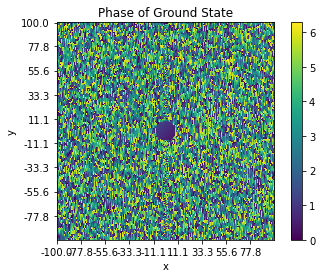

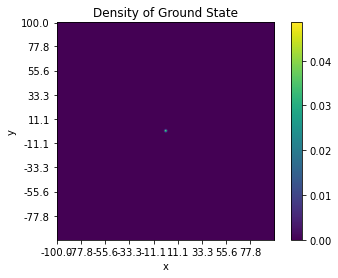

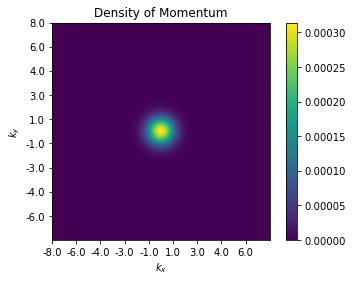

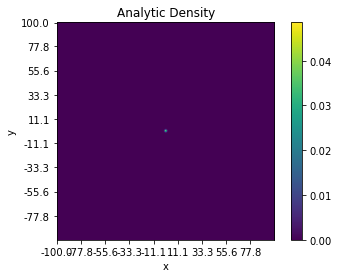

<ipython-input-20-274eb679de6c>:72: RuntimeWarning: divide by zero encountered in true_divide
  compare = np.divide(density,analyticGroundState)
<ipython-input-20-274eb679de6c>:72: RuntimeWarning: invalid value encountered in true_divide
  compare = np.divide(density,analyticGroundState)


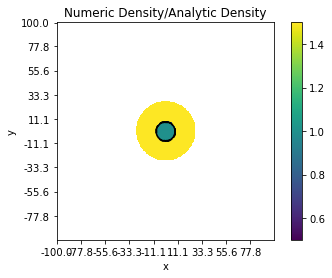

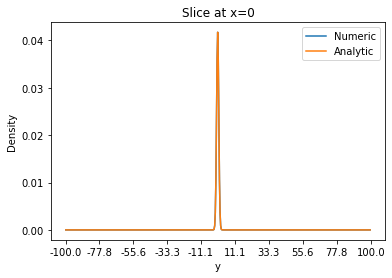

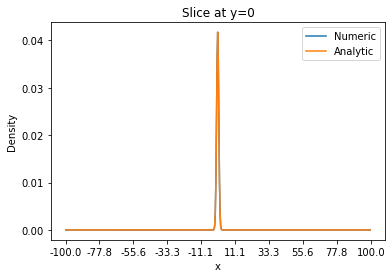

In [20]:
#------------------Plotting Solutions----------------

if rank==0:

    angles = np.angle(groundState)
    angles = (angles%(2*pi)+2*pi)%(2*pi)
    density = np.square(np.abs(groundState))
    Kdensity = np.square(np.abs(buff))
    
    ticks = np.linspace(0,N,10,dtype=int)
    labels = np.round(np.linspace(-xMax,xMax,10),1)
    Klabels = np.round(np.linspace(-pxMax,pxMax,10),0)

#-------------Numeric Ground State

    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.xticks(ticks,labels)
    plt.yticks(ticks,labels[::-1])
    ax.set_title('Phase of Ground State')
    
    plt.imshow(angles, interpolation='none')
    plt.colorbar()
    plt.show()
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.xticks(ticks,labels)
    plt.yticks(ticks,labels[::-1])
    ax.set_title('Density of Ground State')
    
    plt.imshow(density, interpolation='none')
    plt.colorbar()
    plt.show()
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ax.set_xlabel('$k_x$')
    ax.set_ylabel('$k_y$')
    plt.xticks(ticks,Klabels)
    plt.yticks(ticks,Klabels[::-1])
    ax.set_title('Density of Momentum')
    
    plt.imshow(np.fft.fftshift(Kdensity), interpolation='none')
    plt.colorbar()
    plt.show()
    
#----------Analytic Ground State Density
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.xticks(ticks,labels)
    plt.yticks(ticks,labels[::-1])
    ax.set_title('Analytic Density')
    
    plt.imshow(analyticGroundState, interpolation='none')
    plt.colorbar()
    plt.show()
    
#---------Comparison of Analytic and Numeric
    
    compare = np.divide(density,analyticGroundState)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.xticks(ticks,labels)
    plt.yticks(ticks,labels[::-1])
    ax.set_title('Numeric Density/Analytic Density')
    
    plt.imshow(compare, interpolation='none', vmin=0.5, vmax=1.5)
    plt.colorbar()
    con = ax.contour(compare, [0.9,1.1], colors='k', origin='upper')
    ax.clabel(con, inline=1, fontsize=10)
    plt.show()
    

#-------Numeric Slices in X and Y directions
    
    slice = [density[i,int(N/2)] for i in range(N)]
    anSlice = [analyticGroundState[i,int(N/2)] for i in range(N)]
    plt.plot(slice, label="Numeric")
    plt.plot(anSlice, label="Analytic")
    plt.title('Slice at x=0')
    plt.xticks(ticks,labels)
    plt.xlabel('y')
    plt.ylabel('Density')
    plt.legend()
    plt.show()
    
    slice = density[int(N/2)]
    anSlice = analyticGroundState[int(N/2)]
    plt.plot(slice, label="Numeric")
    plt.plot(anSlice, label="Analytic")
    plt.title('Slice at y=0')
    plt.xticks(ticks,labels)
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

## Time Evolution

Once we are happy that we have found the correct ground state, we can use the real time propagators for time evolution. We can then animate this time evolution as in the following code snippet. Simply uncomment the animation that you would like to see!

Here we give the ground state a perturbation by sending $\omega = 1 \rightarrow 2$. This change of the resonance frequency gives rise to 'breathing modes', which exhibits oscillatory behaviour. This can be seen in the following animation. Note you might have to zoom into the middle of the animation, depending on what xMax equals.

<ipython-input-30-8e0721a581d2>:32: ComplexWarning: Casting complex values to real discards the imaginary part
  energyList[i] = totalE


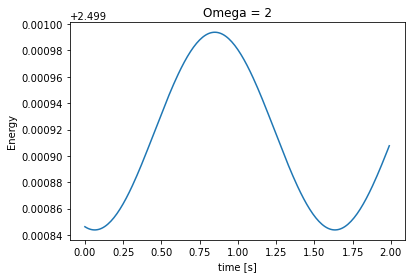

In [30]:
#------Energy of Solution after Ground State reached-----

fps = int(1/h)
nSeconds = 2
snapshots = []
snapshotsPhase = []
snapshotsMom = []
snapshotsXSlice = []
snapshotsYSlice = []
t = 0
w = 2

spaceProp(m,w)
momProp(m,w)

if rank==0:
    energyList = np.zeros(nSeconds*fps)

for i in range(nSeconds*fps):

    u = u.redistribute(1)
    comm.Gather(u,groundState,root=0)
    u = u.redistribute(0)
    
    k = fft.forward(u, k)
    k = normalise(k)
    comm.Gather(k,buff,root=0)
    
    if rank==0:
    
        totalE = energy.energy(groundState,V) + energy.energy(buff,P)
        energyList[i] = totalE
        
        density = np.square(np.abs(groundState))
        snapshots.append(density)
        
        angles = np.angle(groundState)
        angles = (angles%(2*pi)+2*pi)%(2*pi)
        snapshotsPhase.append(angles)
        
        Kdensity = np.square(np.abs(buff))
        snapshotsMom.append(np.fft.fftshift(Kdensity))
        
        snapshotsXSlice.append([density[i,int(N/2)] for i in range(N)])
        snapshotsYSlice.append(density[int(N/2)])
        
    fso_step(UrI,UkI)
    

if rank==0:

#-------------plot how energy changes with time

    plt.plot(np.arange(nSeconds*fps)*h,energyList)
    plt.xlabel('time [s]')
    plt.ylabel('Energy')
    plt.title('Omega = %i' %w)
    plt.show()
    


<IPython.core.display.Javascript object>


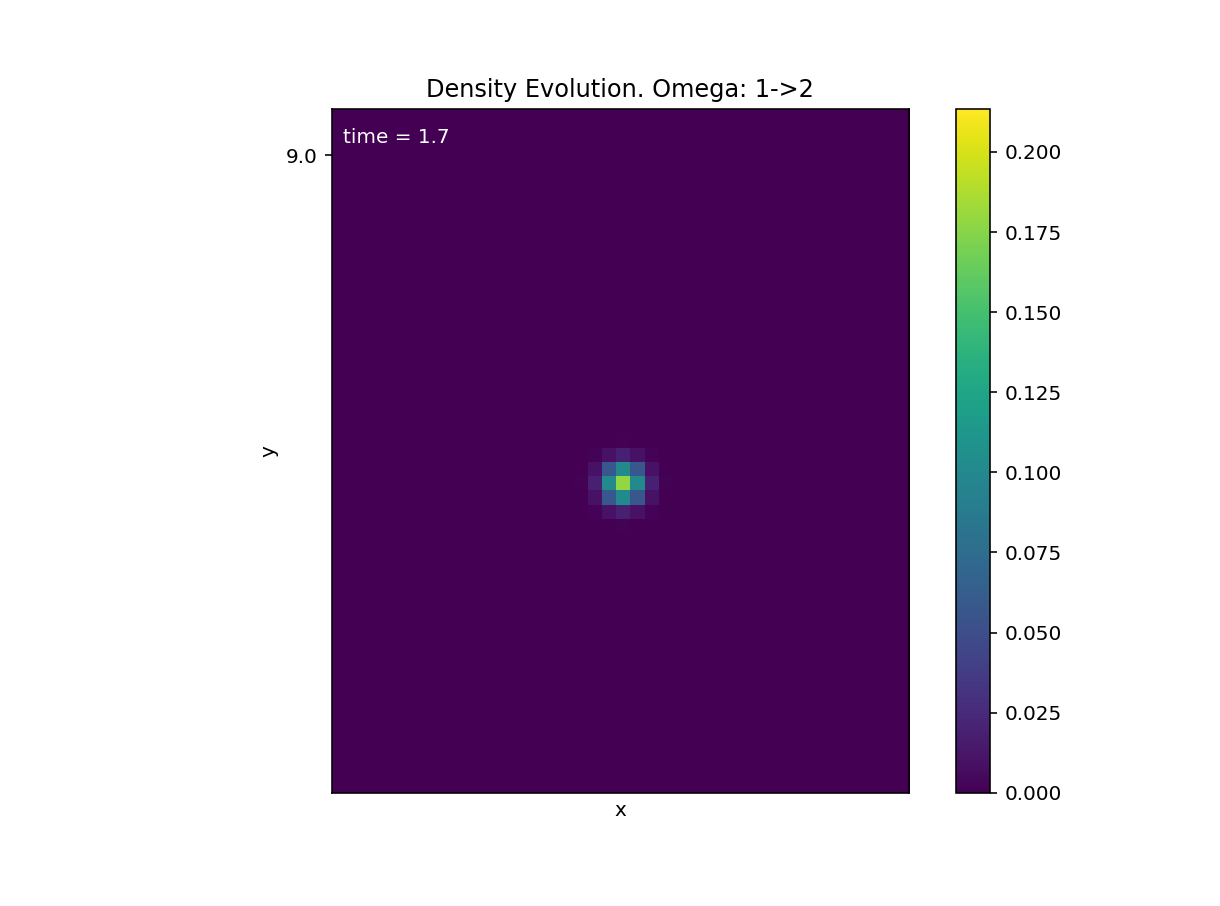

In [33]:
%matplotlib notebook

if rank == 0:

#-------------2D animation of density

    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ticks = np.linspace(0,N,12,dtype=int)
    labels = np.rint(np.linspace(-xMax,xMax,12))
    Klabels = np.round(np.linspace(-pxMax,pxMax,12),0)

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.xticks(ticks,labels)
    plt.yticks(ticks,labels[::-1])
    ax.set_title('Density Evolution. Omega: 1->2')

    def animate_func(i,snapshots,twoD=True):
        if i % fps == 0:
            print( '.', end ='' )
        if twoD==True:
            im.set_array(snapshots[i])
        else:
            im.set_data(x,snapshots[i])
        t = int(i)*0.01
        time_text.set_text('time = %.1f' % t)
        return [im], time_text

    a = snapshots[0]
    im = plt.imshow(a, interpolation='none',vmax=np.max(snapshots)*1.1)
    plt.colorbar()
    time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes,color='white')

    anim = FuncAnimation(
                        fig,
                        animate_func,
                        frames = nSeconds * fps,
                        fargs=(snapshots,),
                        interval = 1000 / fps, # in ms
                        )
    
    plt.show()

## Acknowledgements

This work was based mainly on the work by Dr. Lee O'Riordan's PhD thesis, which can be found at this [link](https://mlxd.github.io/publication/phdthesis/). I would also like to thank the Irish Centre for High End Computing for allowing me to access the national HPC infrastructure, Kay. 